In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# For reproducible random results.
np.random.seed(789)

# The following utility functions are provided for your convenience.
# You may use them in your solution, or you may write your own.
# Do not alter them, and please read the docstrings carefully.
K = np.array([[471.14628085,  -4.94771211, 295.13159043], [0., 436.71106326, 240.96582594], [0., 0., 1.]])
SQUARE_SIZE = 0.0205

## Problem 1.1

(63, 1, 2)


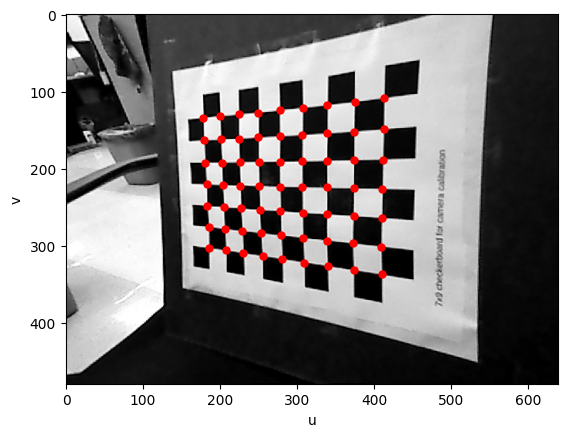

In [31]:
# Read the image from file
img_path = "p1_data/checkerboard.png"
image = cv2.imread(img_path, 0)

# Plot Corners on top of image
fig = plt.figure()
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_ylabel("v")
ax.set_xlabel("u")

# 1) Find the corner locations of the chessboard in image space.
#    Hint: Use the function cv2.findChessboardCorners(image, (num_corners_x, num_corners_y))
#    Hint: findChessboardCorners outputs pixel coordinates!
# 2) Plot their location in image space over top of the image.
#    Hint: use ax.plot(...) -- should be one line!
#    Hint: This should only be 1 line of code!

ncorners_y = 7
ncorners_x = 9
# --------- YOUR CODE STARTS HERE ---------------

ret, corners = cv2.findChessboardCorners(image, (ncorners_x, ncorners_y))
print(corners.shape) # 63 corner points, 1 item per point, 2 coordinates (x,y)
#corners = corners.reshape(-1, 2) # now we have 63 points, 2 coordinates each
# to plot we need the x and y coordinates
#x_coords, y_coords = zip(*corners)
#ax.plot(x_coords, y_coords, 'ro', markersize=5)

ax.plot(corners.reshape(-1, 2)[:,0], corners.reshape(-1, 2)[:,1], 'ro', markersize=5)

# --------- YOUR CODE ENDS HERE -----------------

## Problem 1.2

In [35]:
# 1)  Compute the homography, H.
#     1.a) Use the SQUARE_SIZE, and the dimensions of the grid above to
#             to create a the array P = [[X_0, Y_0, 1], .... [X_n, Y_n, 1]].
#             P should have shape (63, 3).
#          Hint: Use np.meshgrid to generate the X, Y coordinates, and
#             array.reshape and np.hstack to form the final matrix.
#     1.b) Form the M matrix outlined in the write-up!
#     1.c) Use np.linalg.svd(M) to solve for the nullspace of M and recover H.
#          Hint: np.linalg.svd(M) returns V.T.
#          Hint: Use <array>.reshape(3, 3) to give H the proper dimensions.
# 2)  Compute the camera pose rotation, R, and translation, t.
#     2.a) Compute KinvH = inv(K) @ H.
#          Hint: Use np.linalg.inv().
#     2.b) Normalize the values of KinvH to it's first column.
#          Hint: Use np.linalg.norm() and the / operator.
#     2.c) Compute r0, r1, r2, and t as outlined in the write-up.
#          Hint: Use np.cross().
#     2.d) Form R from r0, r1, and r2.
#          Hint: Use np.column_stack()

# --------- YOUR CODE STARTS HERE ---------------

# create the matrix of world coordinates (z-depth of 0)
P = np.zeros((ncorners_x*ncorners_y, 3))
# it has 63 points with 3 coordinates each
for i in range(ncorners_x):
    for j in range(ncorners_y):
        P[i*ncorners_y + j] = [i*SQUARE_SIZE, j*SQUARE_SIZE, 1]

# 1b: form M, where null-space corresponds to the flattened elements of H
# needs to be dimensions 2x9 and we coorespond each 3D coordinate to 2D image coordinate (u,v)
# Extract X and Y from P
X = P[:, 0]
Y = P[:, 1]

# Extract image coordinates (corners) -> (u,v)
u = corners[:, 0, 0]  # if corners is (N,1,2)
v = corners[:, 0, 1]

N = len(X)
M = np.zeros((2 * N, 9))

for i in range(N):
    M[2*i]   = [-X[i], -Y[i], -1, 0, 0, 0, u[i]*X[i], u[i]*Y[i], u[i]]
    M[2*i+1] = [0, 0, 0, -X[i], -Y[i], -1, v[i]*X[i], v[i]*Y[i], v[i]]

# Solve for H using SVD
_, _, Vt = np.linalg.svd(M)
h = Vt[-1]           # last row of V^T
H = h.reshape(3, 3)


# 2)  Compute the camera pose rotation, R, and translation, t.
#     2.a) Compute KinvH = inv(K) @ H.
#          Hint: Use np.linalg.inv().
#     2.b) Normalize the values of KinvH to it's first column.
#          Hint: Use np.linalg.norm() and the / operator.
#     2.c) Compute r0, r1, r2, and t as outlined in the write-up.
#          Hint: Use np.cross().
#     2.d) Form R from r0, r1, and r2.
#          Hint: Use np.column_stack()

K_inv = np.linalg.inv(K)
K_inv_H = K_inv @ H

# normalize K_inv_H to it's first column    
K_inv_H = K_inv_H / np.linalg.norm(K_inv_H[:,0])

# compute r0, r1, r2, and t
r0 = K_inv_H[:,0]
r1 = K_inv_H[:,1]
r2 = np.cross(r0, r1)
t = K_inv_H[:,2]   
# form R
R = np.column_stack((r0, r1, r2))




# --------- YOUR CODE ENDS HERE -----------------

## Problem 1.3

Text(0, 0.5, 'v')

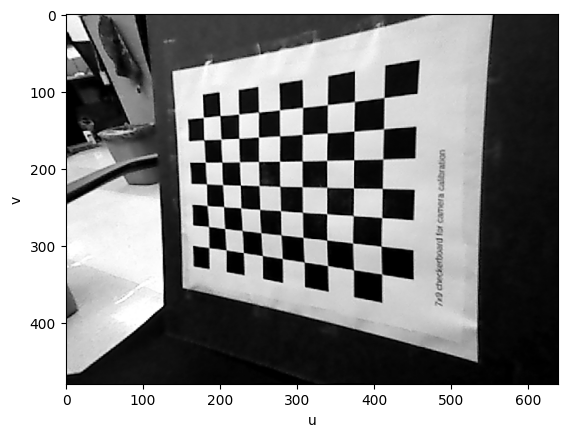

In [ ]:
# 1) Finish the transform_world_to_camera function which uses
#       the given K, and the R and t that you calculated!.
#    Hint: You'll need to use some equations from the write-up.

def transform_world_to_camera(K, R, t, world_coords):
    """
    Args:
        K: np.array with shape (3, 3), camera intrinsics matrix.
        R: np.array with shape (3, 3), camera rotation.
        t: np.array with shape (3, ) or (3, 1), camera translation.
        world_coords: np.array with shape (N, 3), cartesian coordinates (X, Y, Z)
            in world frame to transform into camera pixel space.
    Return:
        uv: np.array with shape (N, 2), with (u, v) coordinates of that are
            the projections of the the world_coords on the image plane.
    """
    # --------- YOUR CODE STARTS HERE ---------------
    # Transform world coordinates to camera coordinates
    # P_camera = R @ P_world + t
    # world_coords is (N, 3), so transpose to (3, N) for matrix multiplication
    camera_coords = (R @ world_coords.T).T + t
    
    uv_homogeneous = (K @ camera_coords.T).T

    uv = uv_homogeneous[:, :2] / uv_homogeneous[:, 2:3]
    
    # --------- YOUR CODE ENDS HERE -----------------
    return uv

ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# 2) Project the global coordinates of the corners that you calculated
#       earlier back onto the image using transform_world_to_camera.
#    Hint: The input world_coords should have shape (63, 3)
#    Hint: Use the Xs and Ys you got earlier and set Zs = 0.
#    Hint: You may need to change some of the variable names at the bottom
#       of this cell to match the names that you used above!

# --------- YOUR CODE STARTS HERE ---------------


# --------- YOUR CODE ENDS HERE -----------------

## Project Anything!
Try using your the camera pose you computed to project our secret point cloud (defined in world coordinates) onto the camera frame!

In [ ]:
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# Load the secrect point cloud from file!
point_cloud_secret = np.load("p1_data/secret.npy")

# NOTE: Uncomment the lines below when you've finished everything else!
# uv_secret = transform_world_to_camera(K, R, t, point_cloud_secret)
# ax.scatter(uv_secret[:, 0], uv_secret[:, 1], s=0.5, c="b")